In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [45]:
#path to the data folder, edit if necesssary
path = "./data/"

#filenames
file_power = "competitor_market_prices_power.csv"
file_gas = "competitor_market_prices_gas.csv"

#Gas Prices 
spot_gas = "eex_spot_gas.csv"
d_ahead_gas = "eex_gas_d.csv"
m_ahead_gas = "eex_gas_m.csv"
y_ahead_gas = "eex_gas_y.csv"

#Power Prices
spot_power = "epex_spot_power.csv"
d_ahead_peak = "eex_power_peak_d.csv"
m_ahead_peak = "eex_power_peak_m.csv"
y_ahead_peak = "eex_power_peak_y.csv"
d_ahead_base = "eex_power_base_d.csv"
m_ahead_base = "eex_power_base_m.csv"
y_ahead_base = "eex_power_base_y.csv"

#Master files
master_power = 'master_competitor_market_prices_power.csv'
master_gas = 'master_competitor_market_prices_gas.csv'


In [46]:
#Reading in power dataset
df_power = pd.read_csv(path + master_power)
df_power

,date_valid_from,date_valid_to,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,price_year_eur,...,d_ahead_peak,d_ahead_base,m_ahead_base,6m_ahead_base,m_ahead_peak,6m_ahead_peak,avg_price,price_kwh,strat_index,validity_period
0,2021-05-25,2021-09-21,51103,Köln,power,500,Criador,Meltan,3.0,260.25,...,0.02646,0.03165,0.06402,0.07535,0.07028,0.09030,0.058416,0.520500,2,119
1,2021-05-25,2021-09-21,51381,Leverkusen,power,500,Criador,Meltan,3.0,257.85,...,0.02646,0.03165,0.06402,0.07535,0.07028,0.09030,0.058416,0.515700,2,119
2,2021-05-25,2021-09-21,51469,Bergisch Gladbach,power,500,Criador,Meltan,3.0,257.85,...,0.02646,0.03165,0.06402,0.07535,0.07028,0.09030,0.058416,0.515700,2,119
3,2021-05-25,2021-09-22,51103,Köln,power,250,Criador,Meltan,3.0,187.62,...,0.02646,0.03165,0.06402,0.07535,0.07028,0.09030,0.058416,0.750480,2,120
4,2021-05-25,2021-09-22,51381,Leverkusen,power,250,Criador,Meltan,2.5,186.42,...,0.02646,0.03165,0.06402,0.07535,0.07028,0.09030,0.058416,0.745680,2,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33161801,2022-10-15,2022-10-15,99089,Erfurt,power,12000,Werra,Banette,9.0,9257.05,...,0.28757,0.25746,0.33663,0.38304,0.44929,0.47385,0.342528,0.771421,2,0
33161802,2022-10-15,2022-10-15,99089,Erfurt,power,12000,Werra,Meditite,12.0,9375.86,...,0.28757,0.25746,0.33663,0.38304,0.44929,0.47385,0.342528,0.781322,2,0
33161803,2022-10-15,2022-10-15,99089,Erfurt,power,20000,Lule älv,Pidove,7.0,15292.50,...,0.28757,0.25746,0.33663,0.38304,0.44929,0.47385,0.342528,0.764625,2,0
33161804,2022-10-15,2022-10-15,99089,Erfurt,power,20000,Sirkos,Magikarp,2.0,13567.83,...,0.28757,0.25746,0.33663,0.38304,0.44929,0.47385,0.342528,0.678392,3,0


In [47]:
def queryPostCodeSupplier(post_code = 81737, supplier = 'Bergwind') -> pd.DataFrame:
    res = df_power.loc[(df_power.post_code == post_code) & (df_power.supplier == supplier)].copy()
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_kwh':'mean', 'spot_base':'mean', 'y_ahead_base':'mean', 'd_ahead_base':'mean', 'm_ahead_base':'mean', '6m_ahead_base':'mean'})
    return res

def queryRangePostCode(consumption_range_kwh = 2000, post_code = 81737) -> pd.DataFrame:
    res = df_power.loc[(df_power.consumption_range_kwh == consumption_range_kwh) & (df_power.post_code == post_code)].copy()
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_kwh':'mean', 'spot_base':'mean', 'y_ahead_base':'mean', 'd_ahead_base':'mean', 'm_ahead_base':'mean', '6m_ahead_base':'mean'})
    return res

def queryPostCodeRankRange(rank = (1,5), post_code = 81737) -> pd.DataFrame:
    res = df_power.loc[(df_power['rank'] >= rank[0]) & (df_power['rank'] <= rank[1]) & (df_power.post_code == post_code)].copy()
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_kwh':'mean', 'spot_base':'mean', 'y_ahead_base':'mean', 'd_ahead_base':'mean', 'm_ahead_base':'mean', '6m_ahead_base':'mean'})
    return res

In [48]:
#Generating dataset for timeseries experiments
df = queryPostCodeRankRange((1,5))
df.set_index(pd.to_datetime(df.index))
df

,price_kwh,spot_base,y_ahead_base,d_ahead_base,m_ahead_base,6m_ahead_base
valid_range,,,,,,
2021-06-12,0.271073,0.078095,0.065660,0.078100,0.072550,0.075840
2021-06-13,0.271073,0.078095,0.065660,0.078100,0.072550,0.075840
2021-06-14,0.271073,0.078095,0.065660,0.078100,0.072550,0.075840
2021-06-15,0.271073,0.078095,0.065660,0.078100,0.072550,0.075840
2021-06-16,0.271073,0.078095,0.065660,0.078100,0.072550,0.075840
...,...,...,...,...,...,...
2022-10-11,0.705504,0.196000,0.442201,0.196000,0.365517,0.417812
2022-10-12,0.709323,0.235965,0.447732,0.235965,0.361898,0.428181
2022-10-13,0.686608,0.287903,0.451789,0.287906,0.359906,0.430998


In [49]:
#Shifting data by 1 to use current energy prices to forecast tomorrow's household prices
real_prices = df.price_kwh
df = df.shift(1)
df.price_kwh = real_prices

#Dropping resulting NA column
df.dropna(inplace=True)

(0.4781591846540043, True)

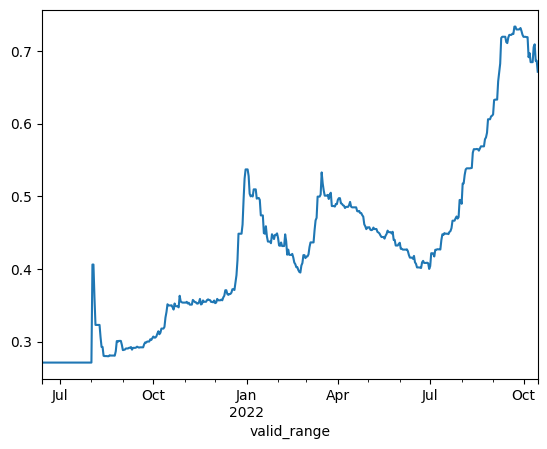

In [50]:
#Plotting timeseries
df.price_kwh.plot()

#Checking for stationarity (p-value lower than 0.05 means that time series is not stationary)
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df[['price_kwh']])

In [57]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

p_values = [0, 1, 2, 3, 4]
d_values = range(0, 4) #this is the range for the values
q_values = range(0, 4) #this is the range for the values

def forecast_nextday_price(X, arima_order, training = 0.90, type = 'df'):
    #Defining exogenous values
    exo = X.drop(columns=['price_kwh'])
    timeseries = np.array(X.price_kwh)

    # prepare training dataset
    train_size = int(len(timeseries) * training)
    train, test = timeseries[:train_size], timeseries[train_size:]
    
    exo_train, exo_test = exo[:train_size], exo[train_size:]
    exo_test.reset_index(inplace = True)
    history = [x for x in train]
    
    # make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, exog = exo[:train_size + t], order = arima_order)
        model_fit = model.fit()
        next = exo_test.iloc[t][1:].astype('float64')
        yhat = model_fit.forecast(steps = 1, exog = next).values[0]
        predictions.append(yhat)
        history.append(test[t])

    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    if type == 'error':
        return error
    res = pd.DataFrame({'real_time_series': history, 'predicted_time_series': list(train) + predictions}, index = df.index)
    res['benchmark_prediction'] = res.real_time_series.shift(1)
    res = res[train_size:]
    return res
    

def forecast_price_long_term(X, arima_order, days, training = 0.90, type = 'df'):
    days = max(days, 1)

    #Defining exogenous values
    exo = X.drop(columns=['price_kwh'])
    timeseries = np.array(X.price_kwh)

    # prepare training dataset
    train_size = int(len(timeseries) * training)
    train, test = timeseries[:train_size], timeseries[train_size:]
    
    exo_train, exo_test = exo[:train_size], exo[train_size:]
    exo_test.reset_index(inplace = True)
    history = [x for x in train]
    
    # make predictions
    predictions = []
    for t in range(0, len(test), days):
        model = ARIMA(history, exog = exo[:train_size + t], order = arima_order)
        model_fit = model.fit()
        next = exo_test.iloc[t,1:].copy()
        next = pd.concat([next] * days, axis = 1, ignore_index= True)
        next = next.transpose().astype('float64')
        yhat = model_fit.forecast(steps = days, exog = next).values
        predictions += list(yhat)
        history += list(test[t:t+days])

    #Cutting off predictions beyond last test value
    test_size = len(test)
    predictions = predictions[:test_size]

    # calculate out of sample error
    error = mean_squared_error(test, predictions[:len(test)])

    if type == 'error':
        return error
    
    #create result dataframe
    res = pd.DataFrame({'real_time_series': history, 'predicted_time_series': list(train) + predictions}, index = X.index)

    #Calculate benchmark predictions (selecting every Nth price and repeating it n times where n is the forecasting period)
    #Building column consisting of real prices for rows in training data, and repeated forecasts for all following rows
    #Training Prices
    bm = X['price_kwh']

    #Separating testing and forecasting prices
    bm_forecast = bm[train_size:]
    bm = bm[:train_size]

    #Selecting rows to repeat
    bm_forecast = bm_forecast.iloc[::days].copy()

    #Duplicating forecasts for amount of days passed in forecast
    bm_forecast = pd.Series(np.repeat(bm_forecast.values, days))

    #Combining baseline predictions and real predictions, and renaming to 'baseline'
    bm = pd.concat([bm, bm_forecast], axis = 0, ignore_index=True)
    bm = bm[:res.shape[0]]
    bm.index = X.index
    
    #Adding benchmark forecasts to res df
    res['benchmark_prediction'] = bm
    
    #cutting off training data for better plotting
    res = res[train_size:]
    return res

In [58]:
def evaluate_models(dataset, p_values, d_values, q_values, days = 1, train_size = 0.70):
    days = max(days, 1)
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    if days == 1:
                        mse = forecast_nextday_price(dataset, order, train_size, 'error')
                    else:
                        mse = forecast_price_long_term(dataset, order, 3, train_size, 'error')
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.6f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.6f' % (best_cfg, best_score))
    return best_cfg

ARIMA(0, 0, 0) MSE=0.009770
ARIMA(0, 0, 1) MSE=0.003164
ARIMA(0, 0, 2) MSE=0.001345
ARIMA(0, 0, 3) MSE=0.001199
ARIMA(0, 1, 0) MSE=0.000080
ARIMA(0, 1, 1) MSE=0.000080
ARIMA(0, 1, 2) MSE=0.000081
ARIMA(0, 1, 3) MSE=0.000079
ARIMA(0, 2, 0) MSE=0.000104
ARIMA(0, 2, 1) MSE=0.000083
ARIMA(0, 2, 2) MSE=0.000069
ARIMA(0, 2, 3) MSE=0.000072
ARIMA(0, 3, 0) MSE=0.000294
ARIMA(0, 3, 1) MSE=0.000105
ARIMA(0, 3, 2) MSE=0.000078
ARIMA(0, 3, 3) MSE=0.000066
ARIMA(1, 0, 0) MSE=0.000130
ARIMA(1, 0, 1) MSE=0.000180
ARIMA(1, 0, 2) MSE=0.000161
ARIMA(1, 0, 3) MSE=0.000164
ARIMA(1, 1, 0) MSE=0.000079
ARIMA(1, 1, 1) MSE=0.000080
ARIMA(1, 1, 2) MSE=0.000082
ARIMA(1, 1, 3) MSE=0.000077
ARIMA(1, 2, 0) MSE=0.000083
ARIMA(1, 2, 1) MSE=0.000072
ARIMA(1, 2, 2) MSE=0.000074
ARIMA(1, 2, 3) MSE=0.000075
ARIMA(1, 3, 0) MSE=0.000182
ARIMA(1, 3, 1) MSE=0.000088
ARIMA(1, 3, 2) MSE=0.000105
ARIMA(1, 3, 3) MSE=0.000065
ARIMA(2, 0, 0) MSE=0.000175
ARIMA(2, 0, 1) MSE=0.000135
ARIMA(2, 0, 2) MSE=0.000119
ARIMA(2, 0, 3) MSE=0

<AxesSubplot: xlabel='valid_range'>

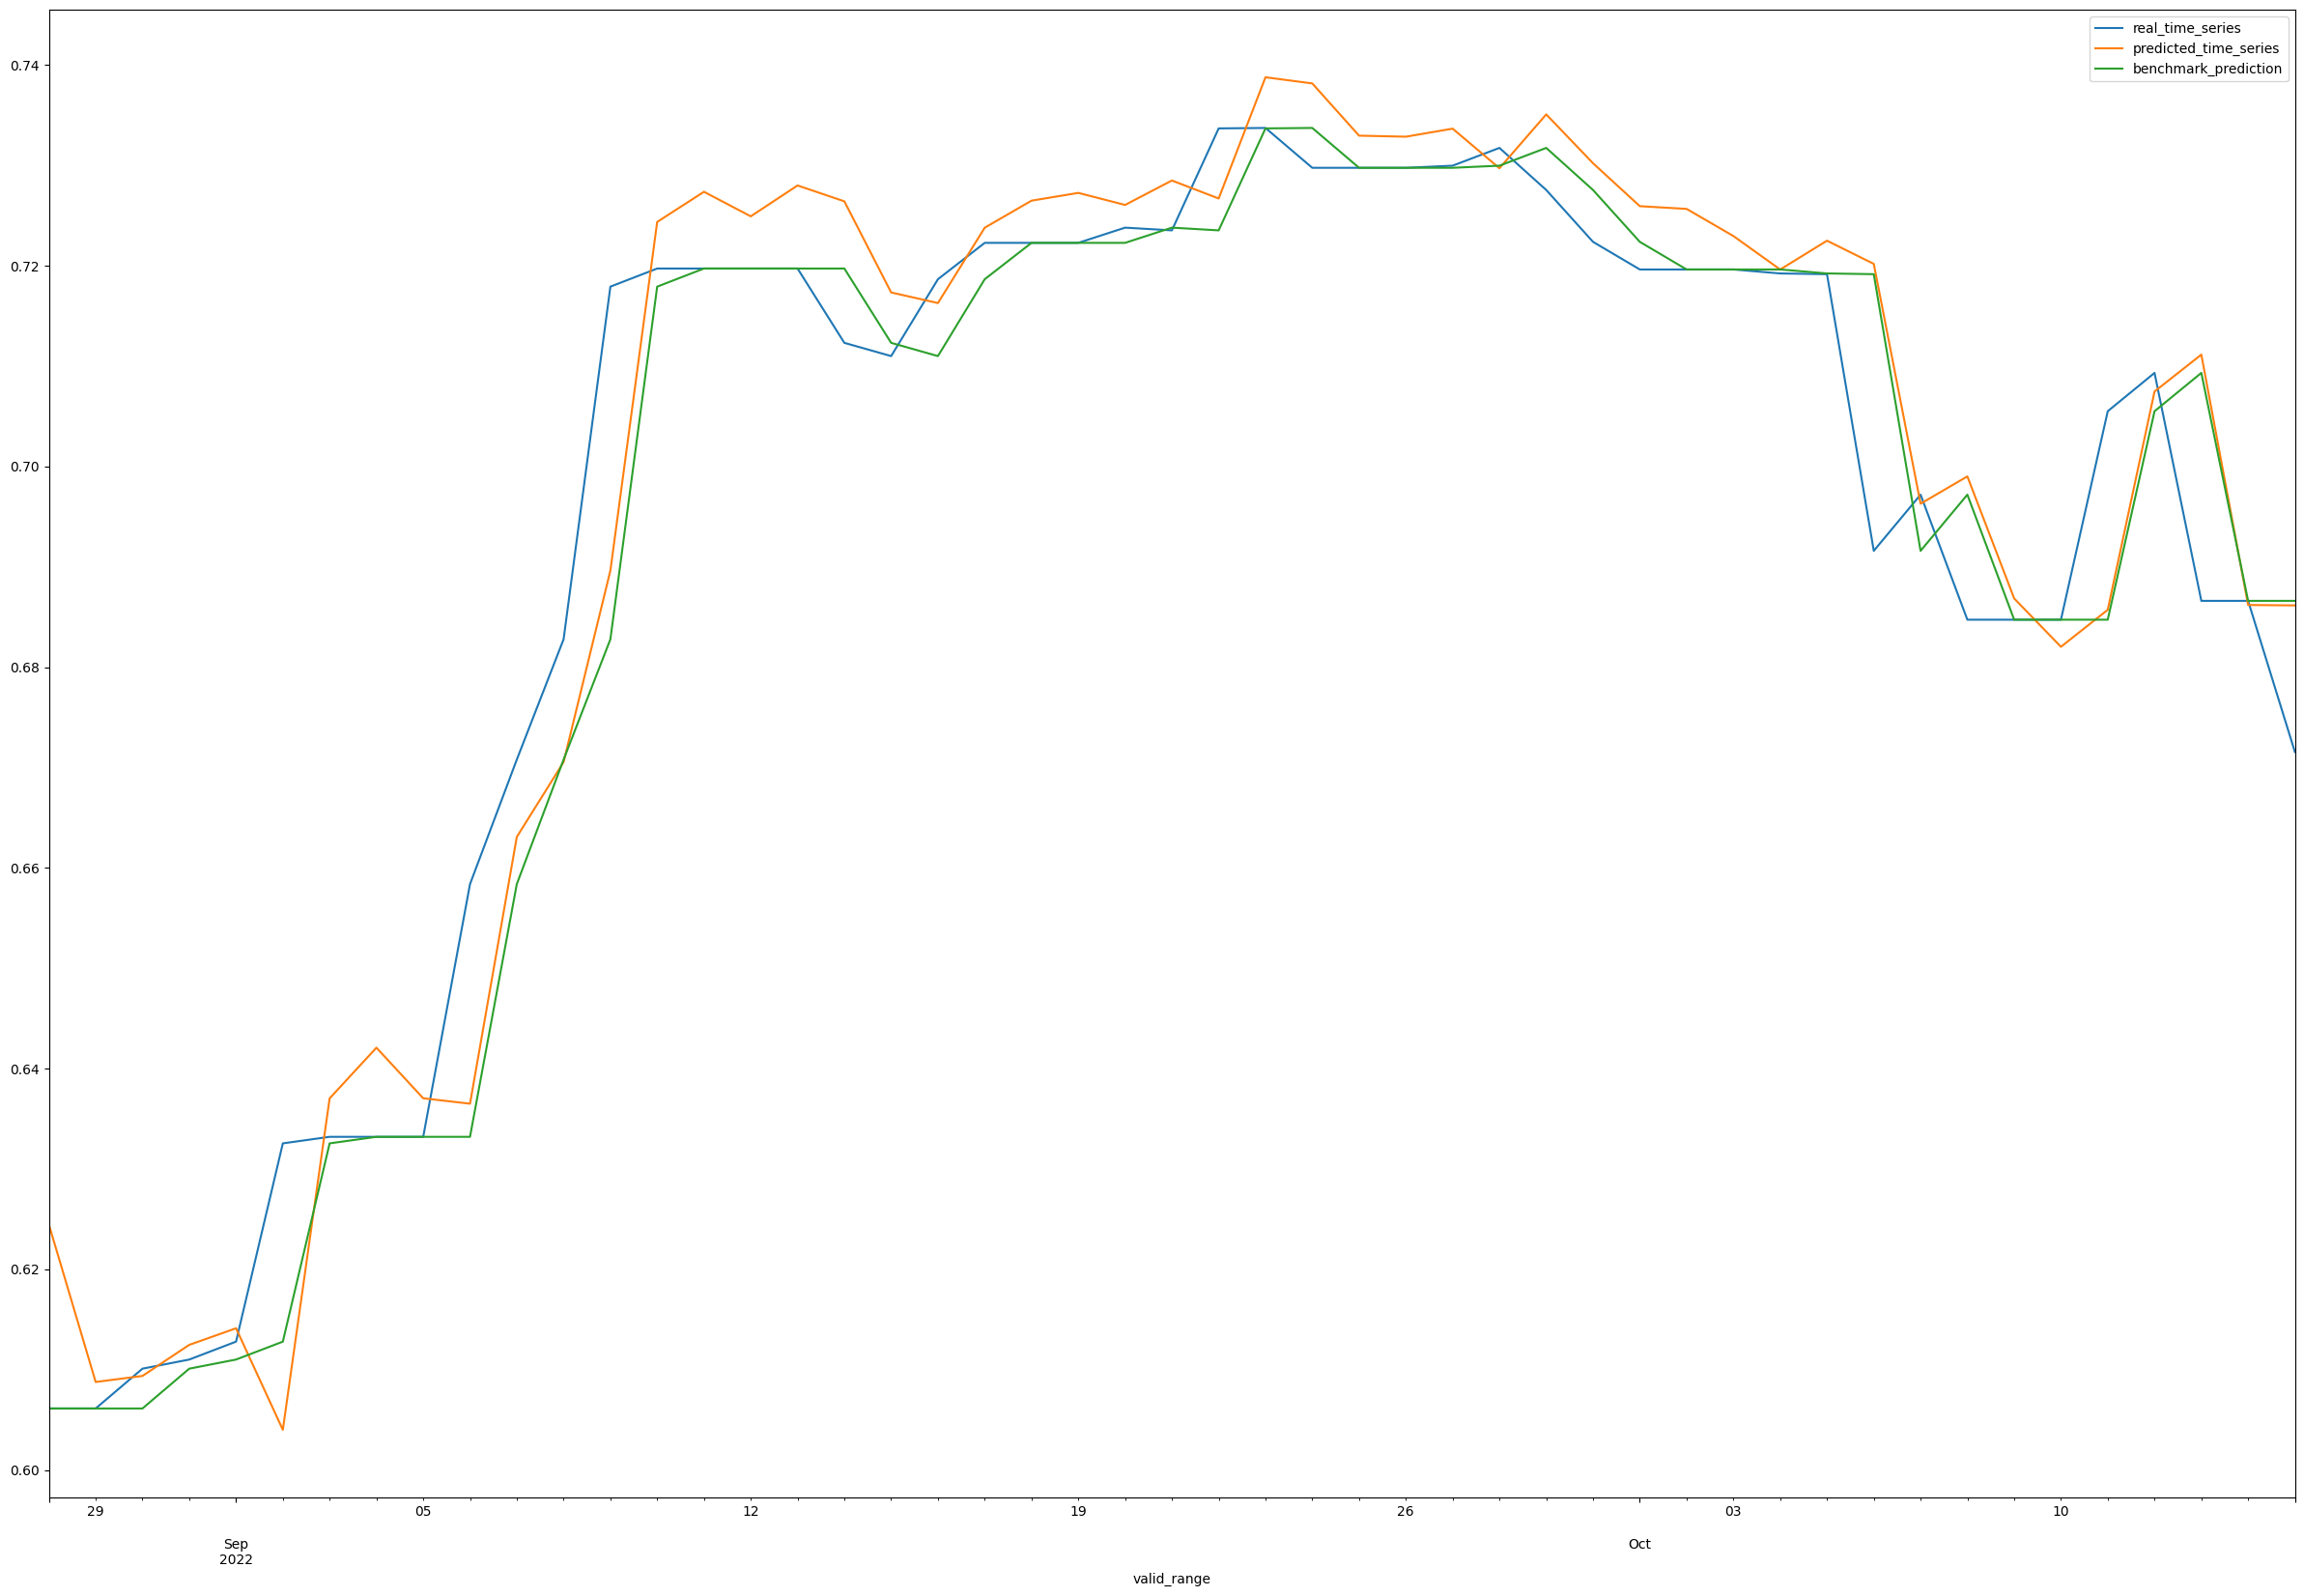

In [53]:
#Benchmarking against the baseline model (which predicts yesterday's price everytime)
res = forecast_nextday_price(df, evaluate_models(df, p_values, d_values, q_values))
res.plot(figsize = (30,20))

In [54]:
#Evaluating MSEs
print('The 1 day ahead baseline model MSE is: ', mean_squared_error(res.real_time_series, res.benchmark_prediction))
print('The best 1 day ahead ARIMA model MSE is: ', mean_squared_error(res.real_time_series, res.predicted_time_series))

The 1 day ahead baseline model MSE is:  0.00010247308497491441
The best 1 day ahead ARIMA model MSE is:  0.00012037218463177128


ARIMA(0, 0, 0) MSE=0.007566
ARIMA(0, 0, 1) MSE=0.005757
ARIMA(0, 0, 2) MSE=0.004216
ARIMA(0, 0, 3) MSE=0.003599
ARIMA(0, 1, 0) MSE=0.000151
ARIMA(0, 1, 1) MSE=0.000152
ARIMA(0, 1, 2) MSE=0.000153
ARIMA(0, 1, 3) MSE=0.000150
ARIMA(0, 2, 0) MSE=0.000257
ARIMA(0, 2, 1) MSE=0.000157
ARIMA(0, 2, 2) MSE=0.000133
ARIMA(0, 2, 3) MSE=0.000131
ARIMA(0, 3, 0) MSE=0.001832
ARIMA(0, 3, 1) MSE=0.000261
ARIMA(0, 3, 2) MSE=0.000144
ARIMA(0, 3, 3) MSE=0.000135
ARIMA(1, 0, 0) MSE=0.000290
ARIMA(1, 0, 1) MSE=0.000417
ARIMA(1, 0, 2) MSE=0.000411
ARIMA(1, 0, 3) MSE=0.000397
ARIMA(1, 1, 0) MSE=0.000151
ARIMA(1, 1, 1) MSE=0.000152
ARIMA(1, 1, 2) MSE=0.000157
ARIMA(1, 1, 3) MSE=0.000148
ARIMA(1, 2, 0) MSE=0.000183
ARIMA(1, 2, 1) MSE=0.000139
ARIMA(1, 2, 2) MSE=0.000137
ARIMA(1, 2, 3) MSE=0.000145
ARIMA(1, 3, 0) MSE=0.000755
ARIMA(1, 3, 1) MSE=0.000199
ARIMA(1, 3, 2) MSE=0.000253
ARIMA(1, 3, 3) MSE=0.000110
ARIMA(2, 0, 0) MSE=0.000370
ARIMA(2, 0, 1) MSE=0.000292
ARIMA(2, 0, 2) MSE=0.000230
ARIMA(2, 0, 3) MSE=0

<AxesSubplot: xlabel='valid_range'>

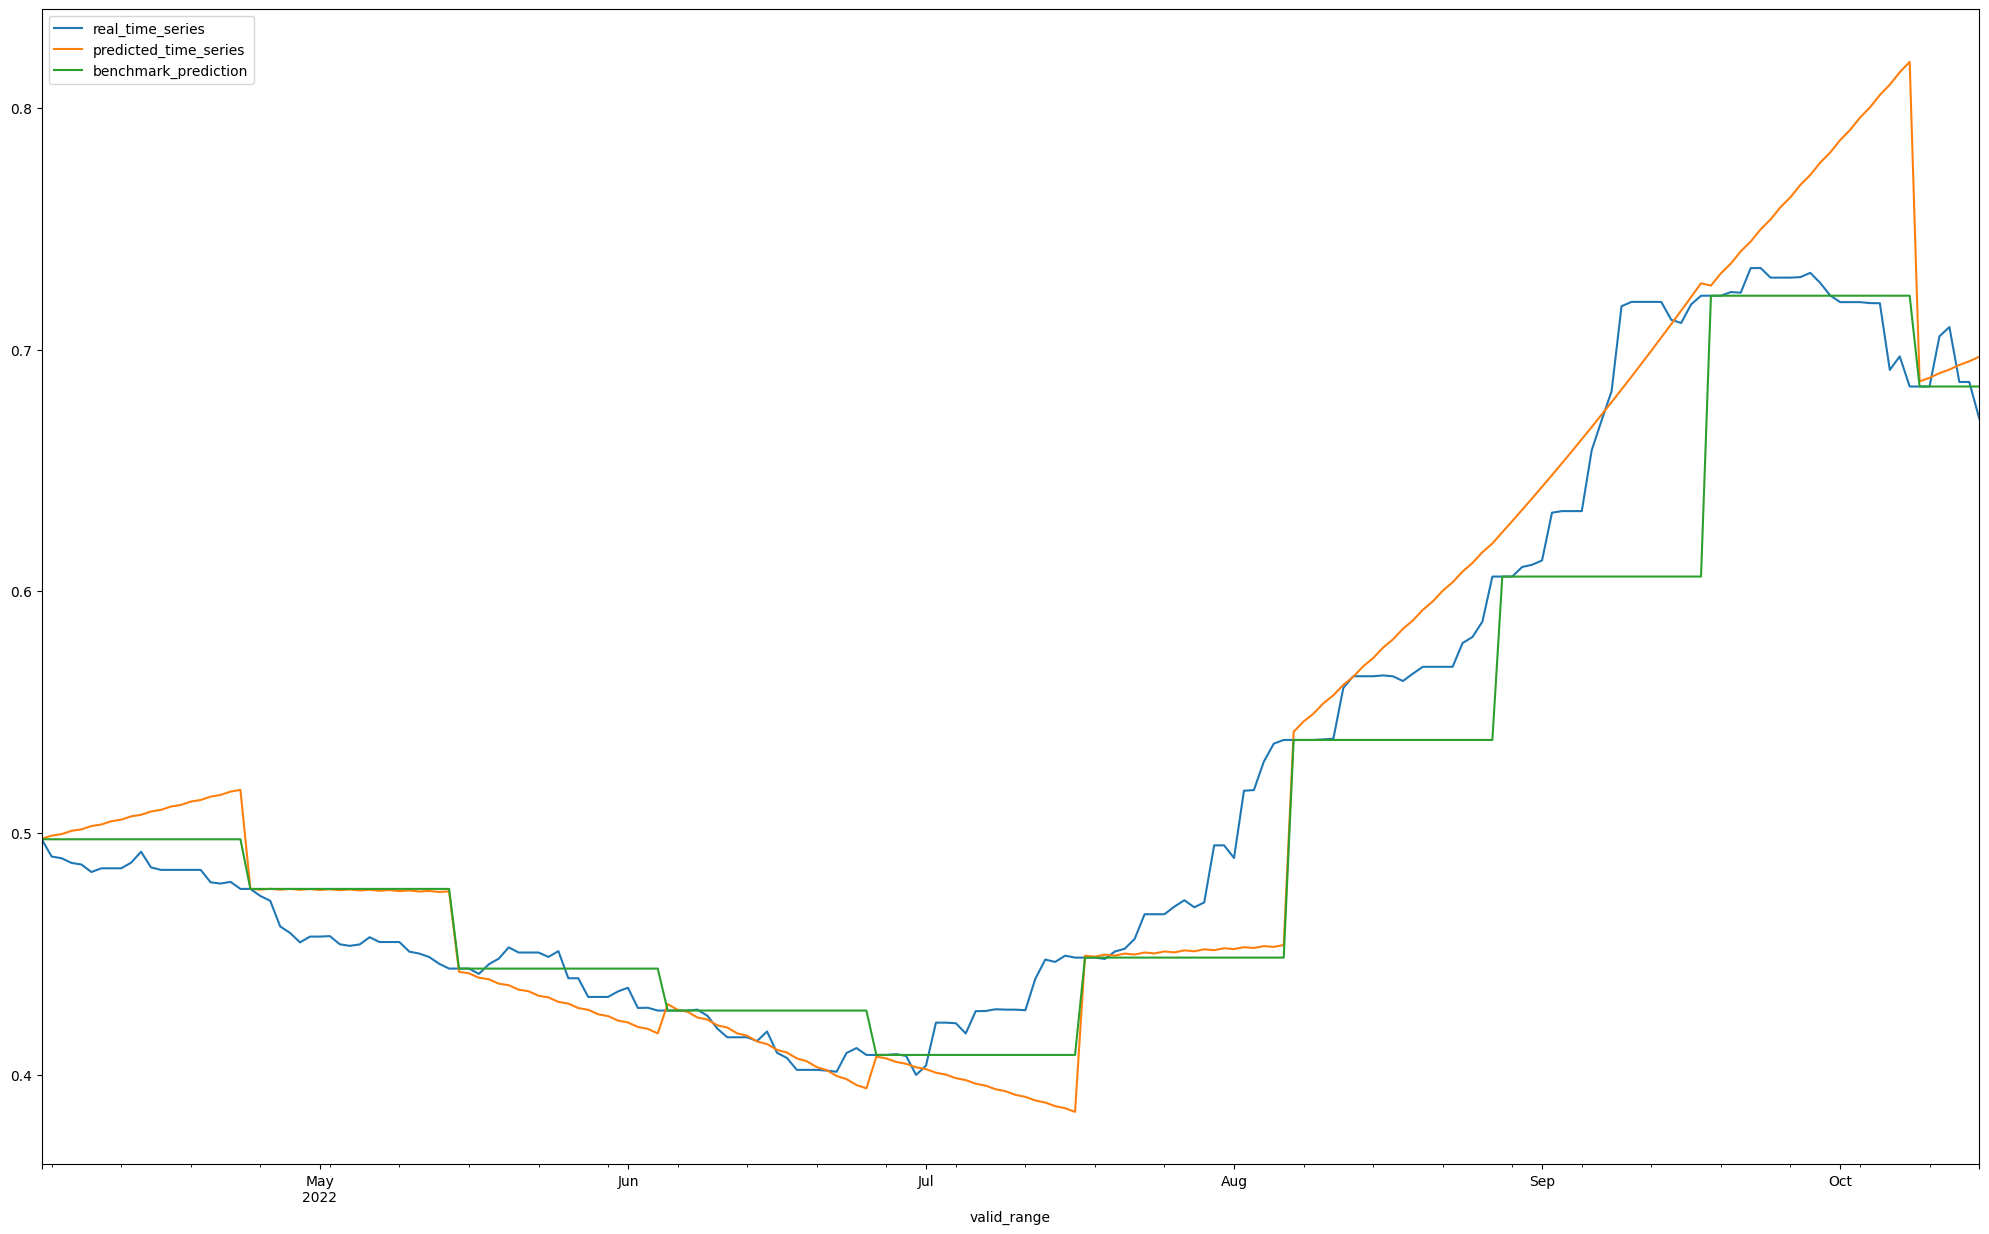

In [60]:
res = forecast_price_long_term(df, evaluate_models(df, p_values, d_values, q_values, 21, 0.60), 21, 0.60, 'df')
res.plot(figsize = (25, 15))

In [61]:
print('The 7 day ahead baseline model MSE is: ', mean_squared_error(res.predicted_time_series, res.benchmark_prediction))
print('The best 7 day ahead ARIMA model MSE is: ', mean_squared_error(res.real_time_series, res.predicted_time_series))

The 7 day ahead baseline model MSE is:  0.0013041935044848121
The best 7 day ahead ARIMA model MSE is:  0.0009884058601929595
